In [1]:
import gym
import gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from copy import deepcopy

In [2]:
"""
General purpose Monte Carlo model for training on-policy methods.
"""

class FiniteMCModel:
    def __init__(self, state_space, action_space, gamma=1.0, epsilon=0.1):
        """MCModel takes in state_space and action_space (finite) 
        Arguments
        ---------
        
        state_space: int OR list[observation], where observation is any hashable type from env's obs.
        action_space: int OR list[action], where action is any hashable type from env's actions.
        gamma: float, discounting factor.
        epsilon: float, epsilon-greedy parameter.
        
        If the parameter is an int, then we generate a list, and otherwise we generate a dictionary.
        >>> m = FiniteMCModel(2,3,epsilon=0)
        >>> m.Q
        [[0, 0, 0], [0, 0, 0]]
        >>> m.Q[0][1] = 1
        >>> m.Q
        [[0, 1, 0], [0, 0, 0]]
        >>> m.pi(1, 0)
        1
        >>> m.pi(1, 1)
        0
        >>> d = m.generate_returns([(0,0,0), (0,1,1), (1,0,1)])
        >>> assert(d == {(1, 0): 1, (0, 1): 2, (0, 0): 2})
        >>> m.choose_action(m.pi, 1)
        0
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = None
        if isinstance(action_space, int):
            self.action_space = np.arange(action_space)
            actions = [0]*action_space
            # Action representation
            self._act_rep = "list"
        else:
            self.action_space = action_space
            actions = {k:0 for k in action_space}
            self._act_rep = "dict"
        if isinstance(state_space, int):
            self.state_space = np.arange(state_space)
            self.Q = [deepcopy(actions) for _ in range(state_space)]
        else:
            self.state_space = state_space
            self.Q = {k:deepcopy(actions) for k in state_space}
            
        # Frequency of state/action.
        self.Ql = deepcopy(self.Q)

        
    def pi(self, action, state):
        """pi(a,s,A,V) := pi(a|s)
        We take the argmax_a of Q(s,a).
        q[s] = [q(s,0), q(s,1), ...]
        """
        if self._act_rep == "list":
            if action == np.argmax(self.Q[state]):
                return 1
            return 0
        elif self._act_rep == "dict":
            if action == max(self.Q[state], key=self.Q[state].get):
                return 1
            return 0
    
    
    def b(self, action, state):
        """b(a,s,A) := b(a|s) 
        Sometimes you can only use a subset of the action space
        given the state.

        Randomly selects an action from a uniform distribution.
        """
        return self.epsilon/len(self.action_space) + (1-self.epsilon) * self.pi(action, state)

    
    def generate_returns(self, ep):
        """Backup on returns per time period in an epoch
        Arguments
        ---------
        
        ep: [(observation, action, reward)], an episode trajectory in chronological order.
        """
        G = {} # return on state
        C = 0 # cumulative reward
        for tpl in reversed(ep):
            observation, action, reward = tpl
            G[(observation, action)] = C = reward + self.gamma*C
        return G
    
    
    def choose_action(self, policy, state):
        """Uses specified policy to select an action randomly given the state.
        Arguments
        ---------
        
        policy: function, can be self.pi, or self.b, or another custom policy.
        state: observation of the environment.
        """
        probs = [policy(a, state) for a in self.action_space]
        return np.random.choice(self.action_space, p=probs)

    
    def update_Q(self, ep):
        """Performs a action-value update.
        Arguments
        ---------
        
        ep: [(observation, action, reward)], an episode trajectory in chronological order.
        """
        # Generate returns, return ratio
        G = self.generate_returns(ep)
        for s in G:
            state, action = s
            q = self.Q[state][action]
            self.Ql[state][action] += 1
            N = self.Ql[state][action]
            self.Q[state][action] = q * N/(N+1) + G[s]/(N+1)
    
    def score(self, env, policy, n_samples=1000):
        """Evaluates a specific policy with regards to the env.
        Arguments
        ---------
        
        env: an openai gym env, or anything that follows the api.
        policy: a function, could be self.pi, self.b, etc.
        """
        rewards = []
        for _ in range(n_samples):
            observation = env.reset()[0]
            cum_rewards = 0
            while True:
                action = self.choose_action(policy, observation)
                observation, reward, done, _ = env.step(action)[:-1]
                cum_rewards += reward
                if done:
                    rewards.append(cum_rewards)
                    break
        return np.mean(rewards)
    
if __name__ == "__main__":
    import doctest
    doctest.testmod()

In [3]:
env = gym.make("Blackjack-v1")
eps = 1000000
S = [(x, y, z) for x in range(4,22) for y in range(1,11) for z in [True,False]]
A = 2
m = FiniteMCModel(S, A, epsilon=1)

In [4]:
for i in range(1, eps+1):
    ep = []
    observation = env.reset()[0]
    while True:
        # Choosing behavior policy
        action = m.choose_action(m.b, observation)

        # Run simulation
        next_observation, reward, done, _ = env.step(action)[:-1]
        ep.append((observation, action, reward))
        observation = next_observation
        if done:
            break

    m.update_Q(ep)
    # Decaying epsilon, reach optimal policy
    m.epsilon = max((eps-i)/eps, 0.1)

In [5]:
print("Final expected returns : {}".format(m.score(env, m.pi, n_samples=10000)))

Final expected returns : -0.0703


In [6]:
X = np.arange(4, 21)
Y = np.arange(1, 10)
Z = np.array([np.array([m.Q[(x, y, False)][0] for x in X]) for y in Y])
X, Y = np.meshgrid(X, Y)

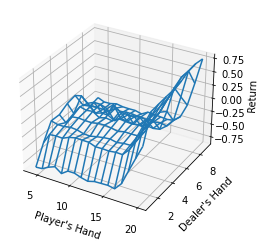

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
ax.set_xlabel("Player's Hand")
ax.set_ylabel("Dealer's Hand")
ax.set_zlabel("Return")
plt.savefig("blackjackpolicy.png")
plt.show()